Semantic JsonSchema types in python.

In [208]:
    import wxyz.json_schema_form.widget_jsonld_schema_form

In [209]:
    import jsonschema, requests, requests_cache, json
    import dataclasses, typing, pandas, toolz.curried as toolz, anyconfig, fastjsonschema
    requests_cache.install_cache('schemas.sqlite')
    import jsonschema, nbformat, collections, hypothesis_jsonschema, importlib, sys

In [210]:
    class Garbage:
        def num_refs(x): return gc.collect() and sys.getrefcount(x)
        def referrers(x): return gc.collect() and gc.get_referrers(x)
        def referents(x): return gc.collect() and gc.get_referents(x)
        def find(self, ns='__main__'):
            hash = id(self)
            return {k for k, v in vars(importlib.import_module(ns)).items() if id(v) == hash}
        
        def type(self): return type(self)

In [211]:
    class JsonSchemaType(__import__('abc').ABCMeta, Garbage):
        __meta_schema__ = jsonschema.Draft7Validator.META_SCHEMA
        def __new__(cls, name, base, kwargs, **schema):
            """Create a new JsonSchemaType type.  Validate the schema on the metaschema. x"""
            self = super().__new__(cls, name, base, kwargs)
            self.__schema__ = dict(collections.ChainMap(schema, *(getattr(cls, '__schema__', {}) for cls in self.__mro__)))
            self.validate_meta_schema(self.__schema__)
            return self
        
        @classmethod
        def validate_meta_schema(cls, object): jsonschema.validate(object, cls.__meta_schema__, format_checker=jsonschema.draft7_format_checker)
        
        @classmethod
        def validate(cls, object): assert isinstance(object, cls)
        
        def __instancecheck__(cls, object):
            try: return jsonschema.validate(object, cls.__schema__, format_checker=jsonschema.draft7_format_checker) or True
            except: return False
                
        def discover(x, object=None, **schema):
            for cls in x.__subclasses__():
                try: return cls.discover(cls(getattr(object, 'object', object)))
                except BaseException as e: ...
            return object
        
        def new(cls, **schema):  
            schema = {**cls.__schema__, **(object if isinstance(object, dict) else {}), **schema}
            return type(schema.get('title', __import__('json').dumps(schema)), (cls,), {}, **schema)
        
        def example(cls):  return hypothesis_jsonschema.from_schema(cls.__schema__).example()

In [212]:
    class JsonSchema(Garbage, metaclass=JsonSchemaType):
        __context__ = F"{jsonschema.Draft7Validator.META_SCHEMA['$schema']}/"
        def __new__(cls, *args, **kwargs):
            if args: assert isinstance(args[0], cls)
            return super().__new__(cls, *args, **kwargs); self.__init__(*args, **kwargs)
        
        def _repr_mimebundle_(x, include=None, exclude=None, **metadata): 
            for k, v in globals().items():
                if k[0].isalpha() and v is getattr(x, 'object', x): metadata['@id'] = k; break
            metadata.update({"@context": {"@vocab": x.__context__}, **x.__schema__, 'examples': [x]})
            return {}, metadata

In [231]:
    class Null(JsonSchema, type='null'): 
        def __new__(cls, object=None, *args, **kwargs): return cls.__schema__.validate(object)
    class Integer(JsonSchema, int, type='integer'): ...
    class Number(JsonSchema, float, type='number'): ...
    class List(JsonSchema, list, type='array'): 
        def __new__(cls, *args, **kwargs): 
            if isinstance(args[0], tuple): args = (list(args[0]),) + args[1:]
            return super().__new__(cls, *args, **kwargs)        
    class Dict(JsonSchema, dict, type='object'): 
        def __new__(cls, *args, **kwargs): 
            args, kwargs = ({**(args and args[0] or {}), **kwargs},), {}
            return super().__new__(cls, *args, **kwargs)        

        def __init_subclass__(cls, **schema): 
            cls.__schema__.update(schema)
            if getattr(cls, '__annotations__', {}):
                cls.__schema__.update(properties={key: value.__schema__ for key, value in getattr(cls, '__annotations__', {}).items() if hasattr(value, '__schema__')})
            cls.validate_meta_schema(cls.__schema__)
            
    class String(JsonSchema, str, type='string'): ...
        
    class NbFormat(Dict, **nbformat.validator._get_schema_json(nbformat.v4)): 
        __context__ = 'https://raw.githubusercontent.com/jupyter/nbformat/master/nbformat/v4/nbformat.v4.schema.json#/'
    class JsonPatch(List, **requests.get("http://json.schemastore.org/json-patch").json()):
        def __call__(self, object): return Type.discover(__import__('jsonpatch').apply_patch(object, self))
    class TableSchema(Dict, **requests.get("https://frictionlessdata.io/schemas/table-schema.json").json()): ...
    class GeoJson(Dict, **requests.get("http://json.schemastore.org/geojson").json()): ...
    class Uri(String, format='uri'): ...
    class Date(String, format='date'): ...
    class Datetime(String, format='date-time'): ...
    class Time(String, format='time'): ...
    class Email(String, format='email'): ...
    class JsonPointer(String, format='json-pointer'): ...
    class File(String): 
        """`File` is only valid if it exists on disk."""
        def validate(self, object):
            if __import__('pathlib').Path(object).exists(): return 
            raise ValueError(F"{object} is not a file.")
    
    class ListofUri(List, items=Uri.__schema__, minItems=1): 
        def text(x): return aiorun(x.gather(json=False))
        def json(x): return aiorun(x.gather())
        
        async def one(self, session, url, json=True):
            async with session.get(url) as response: return await response.json() if json else response.text()
            
        async def gather(x, json=True):
            async with __import__('aiohttp').ClientSession() as session: return await asyncio.gather(*(x.one(session, _, json) for _ in x))

In [232]:
def aiorun(object):
    try: return __import__('asyncio').run(object)
    except RuntimeError as e:
        if 'nest_asyncio' not in sys.modules: __import__('nest_asyncio').apply(); return aiorun(self)
        else: raise e

In [233]:
    class UserObject(JsonSchema):
        """Use abc registration to connect to python types."""
        __context__ = None
        object: None        
        def __new__(cls, *args, **kwargs):  self = object.__new__(cls); self.__init__(*args, **kwargs); return self
        def __post_init__(x): x.object = getattr(x, 'object', x.object); assert isinstance(x.object, type(x))
        def _repr_mimebundle_(x, include=None, exclude=None, **metadata): return {}, metadata
    
    dataclasses.dataclass(UserObject)        
    
    class Pandas(UserObject): 
        def _repr_mimebundle_(x, include=None, exclude=None):
            data, metadata = super()._repr_mimebundle_(include, exclude)
            return data, {**metadata, 'allOf':[
                TableSchema(__import__('json').loads(x.object.to_json(orient='table'))['schema']),
                List.new(minItems=len(x.object), maxItems=len(x.object)).__schema__,]}
        
    Pandas.register(pandas.DataFrame), Pandas.register(pandas.Series)
    
    class Module(UserObject): 
        def _repr_mimebundle_(x, include=None, exclude=None):
            data, metadata = super()._repr_mimebundle_(include, exclude)
            return data, {**metadata, "title": x.object.__name__, "description": x.object.__doc__ or '', "@id": getattr(x.object, '__file__', '')}
    Module.register(__import__('types').ModuleType)

module

In [234]:
    @toolz.do(toolz.partial(setattr, File, 'load'))
    def load(x): 
        return JsonSchema.discover(__import__('anyconfig').load(x))
    @toolz.do(toolz.partial(setattr, File, 'text'))
    def file_text(x): 
        return JsonSchema.discover(__import__('pathlib').Path(x).read_text())
    @toolz.do(toolz.partial(setattr, File, 'json'))
    def file_json(x): 
        return JsonSchema.discover(__import__('json').loads(__import__('pathlib').Path(x).read_text()))
    @toolz.do(toolz.partial(setattr, Uri, 'json'))
    def json(x): return JsonSchema.discover(__import__('requests').get(x).json())
    @toolz.do(toolz.partial(setattr, Uri, 'text'))
    def text(x): return JsonSchema.discover(__import__('requests').get(x).text)


In [235]:
    class DictofDict(Dict, additionalProperties=Dict.__schema__): ...
    class DictofList(Dict, additionalProperties=List.__schema__): ...
    class ListofList(List, additionalProperties=List.__schema__): ...
    class ListofDict(List, additionalProperties=Dict.__schema__): ...

In [236]:
    class Jpeg(String, pattern='[.jpeg|.jpg]$', contentMediaType='image/jpeg'): ...
    class Png(String, pattern='.png$', contentMediaType='image/png'): ...

In [237]:
    class Test(__import__('unittest').TestCase):
        def test_instance(x):
            assert isinstance('http://xx', Uri)
            assert not isinstance('xx', Date)
            assert isinstance('2019-01-01', Date)
            
        def test_discovery(x):
            assert isinstance(JsonSchema.discover(10), Integer)
            assert isinstance(JsonSchema.discover(10.1), Number)
            assert isinstance(JsonSchema.discover('http://thing'), Uri)
            assert isinstance(JsonSchema.discover('jschema.ipynb'), File)
            assert isinstance(JsonSchema.discover('2019-08-01'), Date)
            assert isinstance(JsonSchema.discover({}), Dict)
            assert isinstance(JsonSchema.discover([]), List)
                        
        def test_import(x):
            with __import__('importnb').Notebook(): import jschema
            assert jschema.__file__.endswith('.ipynb')
            
        def test_custom_dict(x):
            class Custom(Dict): a: Integer
            with pytest.raises(AssertionError): Custom(a='asdf')
            assert Custom(a=10)
            
        def test_new_api(x):
            type = String.new(pattern='^x')
            with pytest.raises(AssertionError): type('asdf')            
            assert type('xxxx')
            
        def test_pandas(x):
            assert Pandas(object=pandas.util.testing.makeDataFrame())
            assert isinstance(JsonSchema.discover(pandas.util.testing.makeDataFrame()), Pandas)
    class TestSchemaDiscovery(__import__('unittest').TestCase):
        def test_geojson(x):
            assert not isinstance({'xx': 2}, GeoJson)
            #assert isinstance(File('geojson_sample.geojson').json(), GeoJson)
            
        def test_table_schema(x):
            assert not isinstance({'a': 10}, TableSchema)
            assert isinstance(__import__('json').loads(
                __import__('pandas').util.testing.makeDataFrame().to_json(orient='table'))['schema'], TableSchema)
        
        def test_nb(x):
            assert not isinstance({'a': 10}, NbFormat)
            assert isinstance(File('jschema.ipynb').json(), NbFormat)


In [238]:
    def load_tests(loader, tests, ignore): tests.addTests(doctest.DocTestSuite(importlib.import_module(__name__), optionflags=doctest.ELLIPSIS)); return tests
    if __name__ == '__main__': 
        import unittest, pytest, jsonschema, importlib, doctest
        unittest.main(argv=' ', exit=False, verbosity=1)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.121s

OK


[NbConvertApp] Converting notebook jschema.ipynb to script
[NbConvertApp] Writing 10987 bytes to jschema.py
reformatted jschema.py
All done! ✨ 🍰 ✨
1 file reformatted.
parsing /Users/tonyfast/xxxxx/tonyfast/jschema/jschema.py...


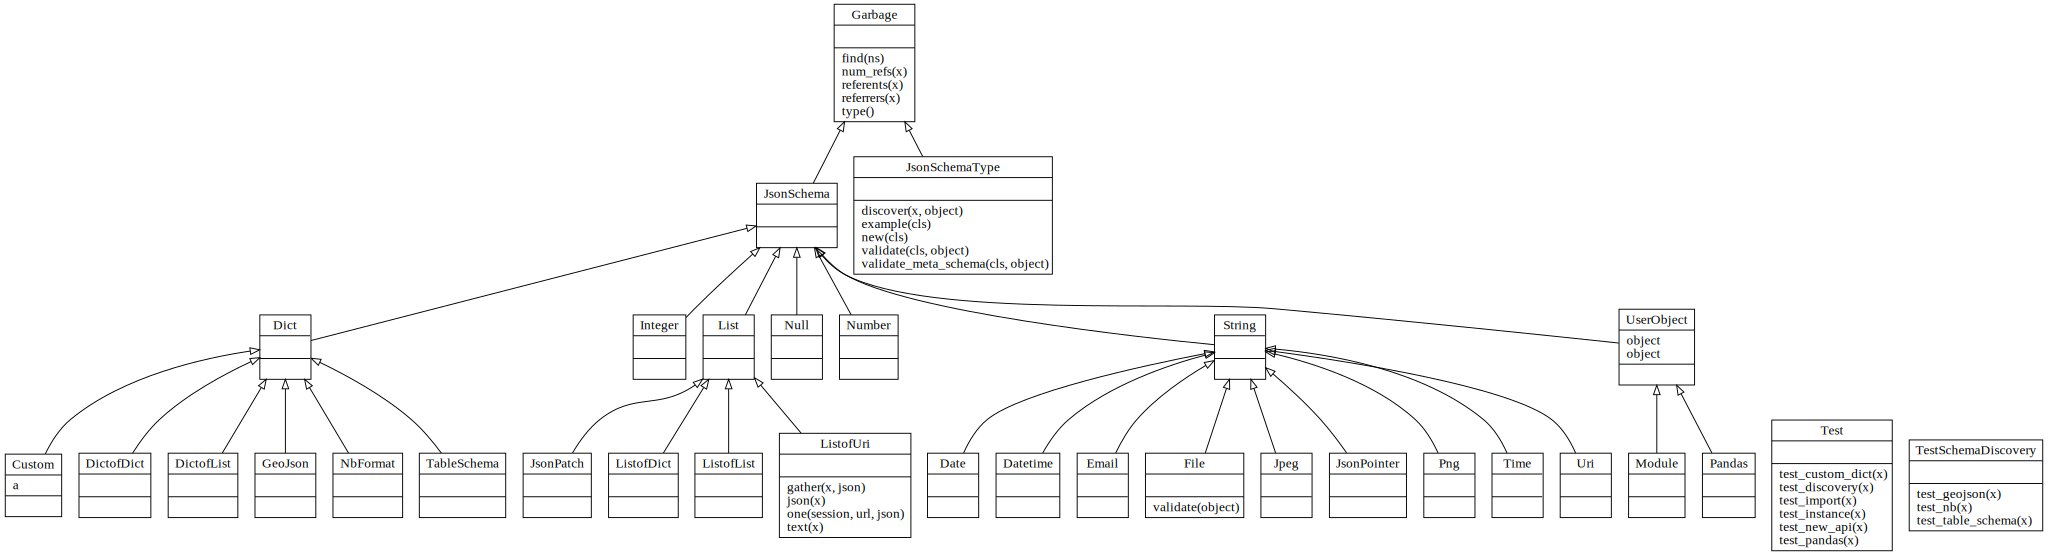

In [239]:
    if __name__ == '__main__': 
        !jupyter nbconvert --to script jschema.ipynb
        !black jschema.py
        !pyreverse jschema -osvg -pjschema
        !rm jschema.py
        display(__import__('IPython').display.SVG('classes_jschema.svg'))